# Adversarial Search: Solving Tic-Tac-Toe with Monte Carlo Tree Search

## Introduction 

Multiplayer games can be implemented as:
1. Nondeterministic actions: The opponent is seen as part of an environment with nondeterministic actions. Non-determinism is the result of the unknown opponent's moves. 
2. Optimal Decisions: Minimax search (search complete game tree) and alpha-beta pruning.
3. Heuristic Alpha-Beta Tree Search: Cut off tree search and use heuristic to estimate state value. 
4. __Monte Carlo Search:__ Simulate playouts to estimate state value. 

Here we will implement search for Tic-Tac-Toe (see [rules](https://en.wikipedia.org/wiki/Tic-tac-toe)). The game is a __zero-sum game__: Win by x results in +1, win by o in -1 and a tie has a value of 0. Max plays x and tries to maximize the outcome while Min plays o and tries to minimize the outcome.   

We will implement
* We enhance Pure Monte Carlo Search by using the upper confidence bound (UCB1) selection policy. That is, we use UCB1 to determine for which action to perform the next playout. This will allow the algorithm to focus on actions here it needs to collect more information. Note that complete Upper Confidence Bounds applied to Trees (UCT) creates a tree and the expand step in the code needs to be added. The tree branch for the chosen move is preserved and used for future moves.

The code for the basic functions used for search are implemented in [tictactoe.py](tictactoe.py). 

In [9]:
from tictactoe import empty_board, actions, result, terminal, utility, other, show_board
from tictactoe import random_player, play 

# Monte Carlo Search with Upper Confidence Bound

See AIMA page 163. 

We enhance pure Monte Carlo Search by using UCB1 as a __selection policy__. This can be seen as a 
restricted version of UTC: 
* Only build a tree of depth 1 and use the UBC1 selection policy.
* Use a random playout policy.


__Note on the playout policy:__ We use here a random playout policy, which ends up creating just a randomized search that works fine for this toy problem. For real applications you need to extend the code with a good __playout policy__ (e.g., manually created heuristics or a neural [network learned by self-play using reinforcement learning](https://towardsdatascience.com/how-to-teach-an-ai-to-play-games-deep-reinforcement-learning-28f9b920440a)).

## Simulate playouts

In [10]:
import numpy as np

def playout(state, action, player = 'x'):
    """Perform a random playout starting with the given action on the given board 
    and return the utility of the finished game."""
    state = result(state, player, action)
    current_player = other(player)
    
    while(True):
        # reached terminal state?
        u = utility(state, player)
        if u is not None: 
            return u
        
        # we use a random playout policy
        a = np.random.choice(actions(state))
        state = result(state, current_player, a)
        #print(state)
        
        # switch between players
        current_player = other(current_player)


board = empty_board()
print(playout(board, 0))
print(playout(board, 0))
print(playout(board, 0))

-1
0
1


## Upper Confidence Bound Applied to Trees (Restricted to Depth 1)

In [11]:
import pandas as pd
import math

DEBUG = 1

def UCT_depth1(board, N = 100, player = 'x'):
    """Upper Confidence bound applied to Trees for limited tree depth of 1. 
    Simulation budget is N playouts."""
    global DEBUG
    
    C = math.sqrt(2) # tradeoff constant
    
    # the tree is 1 action deep
    acts = actions(board)
    
    u = [0] * len(acts) # total utility through actions
    n = [0] * len(acts) # number of playouts through actions
    n_parent = 0 # total playouts so far (i.e., number of playouts through parent)
    
    # make sure we try each action once
    UCB1 = [+math.inf] * len(acts) 
    
    for i in range(N):

        # Select
        action_id = UCB1.index(max(UCB1))
    
        # Expand
        # UTC would expand the tree. We keep the tree at depth 1, essentially performing
        # Pure Monte Carlo search with an added UCB1 selection policy. 
        
        # Simulate
        p = playout(board, acts[action_id], player = player)
    
        # Back-Propagate (i.e., update counts and UCB1)
        u[action_id] += p
        n[action_id] += 1
        n_parent += 1
        
        for action_id in range(len(acts)):
            if n[action_id] > 0:
                UCB1[action_id] = u[action_id] / n[action_id] + C * math.sqrt(math.log(n_parent) / n[action_id])
    
    # return action with largest number of playouts 
    action = acts[n.index(max(n))]
    
    if DEBUG >= 1: 
        print(pd.DataFrame({'action':acts, 
                            'total utility':u, 
                            '# of playouts':n, 
                            'UCB1':UCB1}))
        print()
        print(f"Best action: {action}")
    
    
    return action

In [12]:
board = empty_board()
display(board)

%timeit -n 1 -r 1 UCT_depth1(board, N = 1000)

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

   action  total utility  # of playouts      UCB1
0       0             38            110  0.699849
1       1             28             91  0.697332
2       2             26             87  0.697346
3       3              7             46  0.700204
4       4            238            448  0.706858
5       5             -5             14  0.636246
6       6             25             86  0.691504
7       7              1             33  0.677336
8       8             24             85  0.685510

Best action: 4
250 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Some Tests

### x is about to win (play 8)

Board:


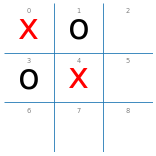


   action  total utility  # of playouts      UCB1
0       2             23             25  1.526971
1       5             12             16  1.508714
2       6              8             13  1.457102
3       7              9             13  1.534025
4       8             33             33  1.528300

Best action: 8
9.07 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'

print("Board:")
show_board(board)

print()
%timeit -n1 -r1 UCT_depth1(board)

### o is about to win

Board:


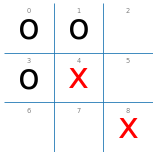


   action  total utility  # of playouts      UCB1
0       2              4            620  0.155727
1       5            -11             11  0.120694
2       6             -5            341  0.186620
3       7            -16             28  0.131004

Best action: 2
129 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
board = empty_board() 
board[0] = 'o'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'
board[8] = 'x'

print("Board:")
show_board(board)

print()
%timeit -n1 -r1 UCT_depth1(board, N = 1000)

### x can draw if it chooses 7

Board:


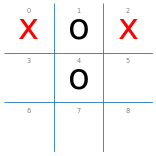


   action  total utility  # of playouts      UCB1
0       3            -12             42  0.287819
1       5             -9             75  0.309193
2       6            -11             26  0.305871
3       7            141            790  0.310723
4       8            -10             67  0.304841

Best action: 7
149 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[2] = 'x'
board[4] = 'o'

print("Board:")
show_board(board)

print()
%timeit -n1 -r1 UCT_depth1(board, N = 1000)

### Empty board: Only a draw an be guaranteed

Board:


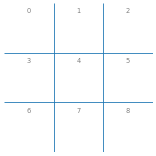


   action  total utility  # of playouts      UCB1
0       0             11             23  1.111072
1       1              1              9  1.122729
2       2             -2              2  1.145966
3       3              3             12  1.126087
4       4             -2              6  0.905641
5       5              0              8  1.072983
6       6              4             15  1.050263
7       7              6             16  1.133714
8       8              0              9  1.011618

Best action: 0
33.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
   action  total utility  # of playouts      UCB1
0       0             24            121  0.573554
1       1             30            135  0.577441
2       2            135            372  0.576892
3       3             28            131  0.574342
4       4           1834           3591  0.579595
5       5              3             63  0.567607
6       6             85            264  0.575986
7       7         

In [16]:
board = empty_board() 

print("Board:")
show_board(board)


print()
%timeit -n1 -r1 UCT_depth1(board, N = 100)
%timeit -n1 -r1 UCT_depth1(board, N = 5000)

### A bad situation

Board:


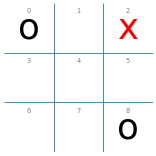


   action  total utility  # of playouts      UCB1
0       1             -4             12  0.542754
1       3             -4              4  0.517427
2       4              3             42  0.539717
3       5             -4              4  0.517427
4       6             -2             26  0.518261
5       7             -5             12  0.459420

Best action: 4


4

In [17]:
board = empty_board() 
board[0] = 'o'
board[2] = 'x'
board[8] = 'o'

print("Board:")
show_board(board)


print()
display(UCT_depth1(board))

__Note:__ It looks like random player o is very unlikely to block x and take advantage of the trap by playing the bottom left corner!

## Experiments

### Pure Monte Carlo Search vs. Random

In [18]:
def ucb1_10_player(board, player = 'x'):
    action = UCT_depth1(board, N = 10, player = player)
    return action

def ucb1_100_player(board, player = 'x'):
    action = UCT_depth1(board, N = 100, player = player)
    return action

In [19]:
DEBUG = 0
print("UCB1 (10) vs. random:")
%timeit -n1 -r1 display(play(ucb1_10_player, random_player))

print()
print("random vs. UCB1 (10):")
%timeit -n1 -r1 display(play(random_player, ucb1_10_player))

UCB1 (10) vs. random:


{'x': 91, 'o': 6, 'd': 3}

427 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

random vs. UCB1 (10):


{'x': 20, 'o': 71, 'd': 9}

339 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [20]:
DEBUG = 0
print("UCB1 (100) vs. random:")
%timeit -n 1 -r 1 display(play(ucb1_100_player, random_player))

print()
print("random vs. UCB1 (100):")
%timeit -n 1 -r 1 display(play(random_player, ucb1_100_player))

UCB1 (100) vs. random:


{'x': 99, 'o': 0, 'd': 1}

3.74 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

random vs. UCB1 (100):


{'x': 4, 'o': 85, 'd': 11}

4.41 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [21]:
DEBUG = 0
print("UCB1 (100) vs. UCB1 (10):")
%timeit -n 1 -r 1 display(play(ucb1_100_player, ucb1_10_player))

print()
print("UCB1 (10) vs. UCB1 (100):")
%timeit -n 1 -r 1 display(play(ucb1_10_player, ucb1_100_player))

UCB1 (100) vs. UCB1 (10):


{'x': 88, 'o': 1, 'd': 11}

6.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

UCB1 (10) vs. UCB1 (100):


{'x': 32, 'o': 53, 'd': 15}

4.74 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
